In [96]:
# module imports


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# model imports
from keras.models import Sequential
from keras.layers import MaxPooling1D, LSTM, Dense, Flatten
from keras.layers import Dropout,Convolution1D
from keras.models import load_model


# processing imports
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('Welcome!')

Welcome!


In [97]:
#Features and labels are identified based on the dataset columns.
#The NSL-KDD dataset is loaded using Pandas, and its structure is explored.
train='/Users/abhaydhek/Desktop/NSL KDD Dataset/archive (6)/nsl-kdd/KDDTrain+.txt'
test='/Users/abhaydhek/Desktop/NSL KDD Dataset/archive (6)/nsl-kdd/KDDTest+.txt'

featureV=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
          "dst_host_samea_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

flagV=['OTH','RSTOS0','SF','SH','RSTO','S2','S1','REJ','S3','RSTR','S0']

protocol_typeV=['tcp','udp','icmp']

serviceV=['http','smtp','finger','domain_u','auth','telnet','ftp','eco_i','ntp_u','ecr_i','other','private','pop_3','ftp_data',
                  'rje','time','mtp','link','remote_job','gopher','ssh','name','whois','domain','login','imap4','daytime','ctf','nntp',
                  'shell','IRC','nnsp','http_443','exec','printer','efs','courier','uucp','klogin','kshell','echo','discard','systat',
                  'supdup','iso_tsap','hostnames','csnet_ns','pop_2','sunrpc','uucp_path','netbios_ns','netbios_ssn','netbios_dgm',
                  'sql_net','vmnet','bgp','Z39_50','ldap','netstat','urh_i','X11','urp_i','pm_dump','tftp_u','tim_i','red_i','icmp',
                  'http_2784','harvest','aol','http_8001']

binary_attack=['normal','ipsweep', 'nmap', 'portsweep','satan', 'saint', 'mscan','back', 'land', 'neptune', 'pod', 'smurf',
               'teardrop', 'apache2', 'udpstorm', 'processtable','mailbomb','buffer_overflow', 'loadmodule', 'perl', 'rootkit',
               'xterm', 'ps', 'sqlattack','ftp_write', 'guess_passwd', 'imap', 'multihop','phf', 'spy', 'warezclient',
               'warezmaster','snmpgetattack','named', 'xlock', 'xsnoop','sendmail', 'httptunnel', 'worm', 'snmpguess']

multiclass_attack={ 'normal': 'normal',
        'probe': ['ipsweep.', 'nmap.', 'portsweep.','satan.', 'saint.', 'mscan.'],
        'dos': ['back.', 'land.', 'neptune.', 'pod.', 'smurf.','teardrop.', 'apache2.', 'udpstorm.', 'processtable.','mailbomb.'],
        'u2r': ['buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.','xterm.', 'ps.', 'sqlattack.'],
        'r2l': ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.','phf.', 'spy.', 'warezclient.', 'warezmaster.','snmpgetattack.',
                   'named.', 'xlock.', 'xsnoop.','sendmail.', 'httptunnel.', 'worm.', 'snmpguess.']}

In [98]:
#reading the datasets used in the project
train_data=pd.read_csv(train,names=featureV)
test_data=pd.read_csv(test,names=featureV)

In [ ]:
train_data = train_data.query("service != 'aol'")
train_data = train_data.query("service != 'harvest'")
train_data = train_data.query("service != 'http_2784'")
train_data = train_data.query("service != 'http_8001'")
train_data = train_data.query("service != 'red_i'")
train_data = train_data.query("service != 'urh_i'")
train_data = train_data.query("service != 'printer'")
train_data = train_data.query("service != 'rje'")


test_data = test_data.query("service != 'printer'")
test_data = test_data.query("service != 'rje'")
test_data.size()
train_data.size()

In [100]:
def bar_graph(feature):
    train_data[feature].value_counts().plot(kind="bar")

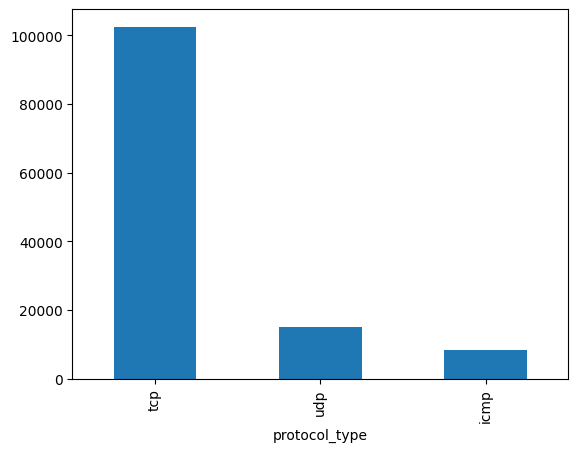

In [101]:
bar_graph('protocol_type')
#It visualizes the distribution of different protocol types, such as 'tcp,' 'udp,' and 'icmp.'

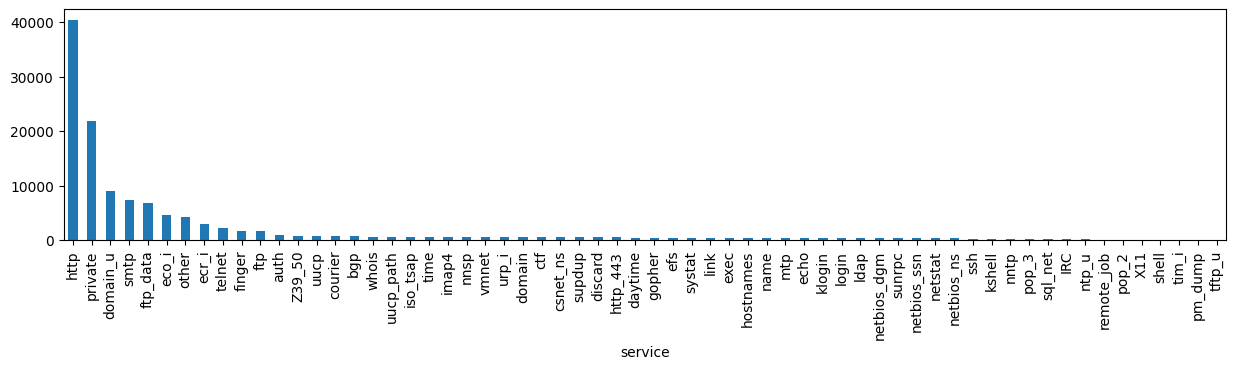

In [102]:
plt.figure(figsize=(15,3))
bar_graph('service')
#It visualizes the distribution of different network services.

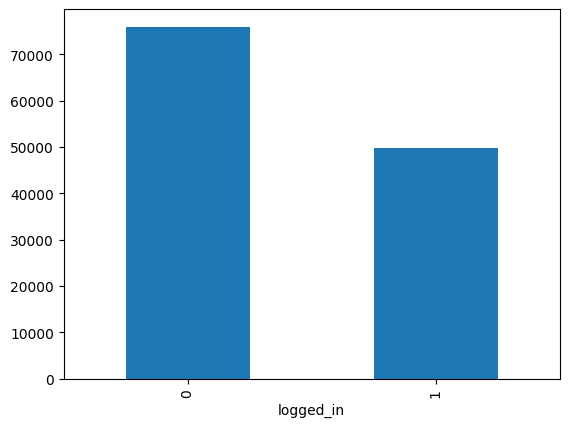

In [103]:
bar_graph('logged_in')
#It visualizes the distribution of the 'logged_in' binary feature, indicating whether a user is logged in or not.

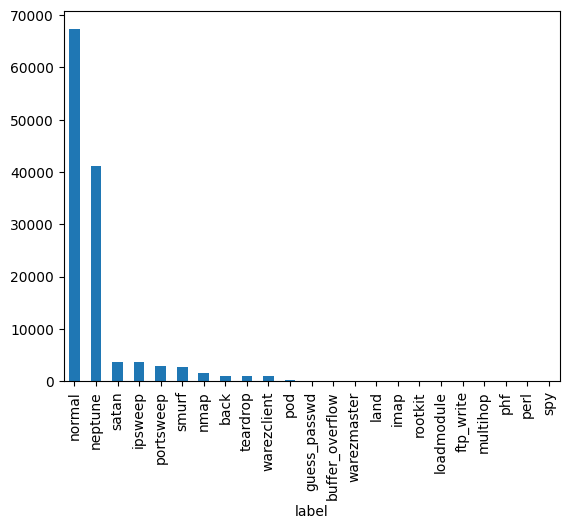

In [104]:
bar_graph('label')
#It visualizes the distribution of different attack types or the 'normal' class.

In [105]:
#The dataset is preprocessed to remove certain services that are not needed for the project.
#Categorical labels are mapped to binary values for binary classification.
#Feature vectors are created through one-hot encoding for categorical features.
#Labels are converted to binary vectors.
def preprocessing(data,cls,df):

#attack categorization
  data['label']=data['label'].replace(['normal.','normal'],0)

#binary classification-
  if cls=='binary':
    for i in range(len(binary_attack)):
      data['label'] = data['label'].replace(binary_attack[i], 1)

#multiclass classification
  elif cls=='multiclass':
    for i in range(len(multiclass_attack['probe'])):
      data['label']=data['label'].replace([multiclass_attack['probe'][i],multiclass_attack['probe'][i][:-1]],1)

    for i in range(len(multiclass_attack['dos'])):
      data['label']=data['label'].replace([multiclass_attack['dos'][i],multiclass_attack['dos'][i][:-1]],2)

    for i in range(len(multiclass_attack['u2r'])):
      data['label']=data['label'].replace([multiclass_attack['u2r'][i],multiclass_attack['u2r'][i][:-1]],3)

    for i in range(len(multiclass_attack['r2l'])):
      data['label'] = data['label'].replace([multiclass_attack['r2l'][i],multiclass_attack['r2l'][i][:-1]],4)
  
  y = data['label']
  x = data.loc[:, 'duration':'hot']
    # Check DataFrame structure
  print("DataFrame Shape:", data.shape)
  print("Column Names:", data.columns)

    # Print a few rows of the DataFrame
  print("Sample Data:")
  print(data.head())

    # Splitting features and labels
  
  


#converting to binary feature vectors
  t=x.protocol_type.copy()
  t=pd.get_dummies(t)
  x=x.drop(columns='protocol_type',axis=1)
  x=x.join(t)

  t1=x.service.copy()
  t1=pd.get_dummies(t1)
  x=x.drop(columns='service',axis=1)
  x=x.join(t1)

  t2=x.flag.copy()
  t2=pd.get_dummies(t2)
  x=x.drop(columns='flag',axis=1)
  x=x.join(t2)


#converting to binary label vectors
  yt=y.copy()
  yt=pd.get_dummies(yt)

  x = MinMaxScaler(feature_range=(0, 1)).fit_transform(x)

  if df=='train':
    return x,yt
  else:
    return x,y


In [106]:
#The dataset is split into training and testing sets for model evaluation.
x_train,Y_train=preprocessing(train_data,cls='binary',df='train')
x_test,Y_test=preprocessing(test_data,cls='binary',df='test')

DataFrame Shape: (125793, 43)
Column Names: Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_samea_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'difficulty'],
      dtype='object')
Sample Data:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0    

In [107]:

#Data is further reshaped to fit the CNN+LSTM model input requirements.
print(np.shape(x_train))
print(np.shape(Y_train))
print(np.shape(x_test))
print(np.shape(Y_test))

(125793, 83)
(125793, 2)
(22525, 83)
(22525,)


In [108]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(125793, 83, 1)

In [109]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(22525, 83, 1)

In [110]:
#A Convolutional Neural Network (CNN) with Long Short-Term Memory (LSTM) layers is implemented.
def create_cnn_lstm_model():
    model = Sequential()
    model.add(Convolution1D(32, 3, padding="same", activation="relu", input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=(4)))
    model.add(Dropout(0.5))
    model.add(LSTM(64, activation="relu", return_sequences=True))
    model.add(Convolution1D(64, 3, padding="same", activation="relu"))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [119]:
cnn_lstm_model = create_cnn_lstm_model()
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_lstm_model.fit(x_train, Y_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
1573/1573 [==============================] - 18s 11ms/step - loss: 0.1813 - accuracy: 0.9396 - val_loss: 0.1333 - val_accuracy: 0.9563
Epoch 2/50
1573/1573 [==============================] - 17s 11ms/step - loss: 0.1476 - accuracy: 0.9525 - val_loss: 0.1318 - val_accuracy: 0.9567
Epoch 3/50
1573/1573 [==============================] - 17s 11ms/step - loss: 0.1415 - accuracy: 0.9536 - val_loss: 0.1231 - val_accuracy: 0.9585
Epoch 4/50
1573/1573 [==============================] - 17s 11ms/step - loss: 0.1241 - accuracy: 0.9554 - val_loss: 0.1018 - val_accuracy: 0.9648
Epoch 5/50
1573/1573 [==============================] - 17s 11ms/step - loss: 0.1133 - accuracy: 0.9598 - val_loss: 0.1005 - val_accuracy: 0.9648
Epoch 6/50
1573/1573 [==============================] - 17s 11ms/step - loss: 0.1109 - accuracy: 0.9606 - val_loss: 0.0975 - val_accuracy: 0.9642
Epoch 7/50
1573/1573 [==============================] - 17s 11ms/step - loss: 0.1088 - accuracy: 0.9611 - val_loss: 0.0977 -

In [120]:
# Save the trained model to a file
cnn_lstm_model.save('cnnlstm_model.keras')


# ... (rest of the code)

# Load the saved model before evaluating it on the test set
saved_model = load_model('cnnlstm_model.keras')

# The trained model is evaluated on the testing set to assess its performance.
# The confusion matrix is calculated, and accuracy is computed for model evaluation.

In [121]:
#The CNN+LSTM model is trained on the preprocessed training data.
#The training involves adjusting model parameters to minimize the difference between predicted and actual labels.
pred = cnn_lstm_model.predict(x_test)
y_pred= np.argmax(pred, axis = 1)

704/704 [==============================] - 1s 2ms/step


In [122]:
#The trained model is evaluated on the testing set to assess its performance.
#The confusion matrix is calculated, and accuracy is computed for model evaluation.
confusion_matrix(Y_test, y_pred)

array([[ 8717,   994],
       [ 2597, 10217]])

In [123]:
accuracy =accuracy_score(Y_test, y_pred)*100
print(accuracy)

84.05771365149833


In [124]:
print(y_pred)
# print(len(y_pred))

[1 1 0 ... 1 0 1]


In [125]:
recall = recall_score(Y_test, y_pred , average="binary")
precision = precision_score(Y_test, y_pred , average="binary")
f1 = f1_score(Y_test, y_pred, average="binary")

In [126]:
print("F-Score : ", f1*100)
print("Precision : " , precision*100)
print("Recall : ", recall*100)
print("Accuracy : ",accuracy)

F-Score :  85.05306971904267
Precision :  91.13370796539112
Recall :  79.73310441704385
Accuracy :  84.05771365149833
